In [1]:
#Inspired by https://avandekleut.github.io/vae/
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)
tmp = FF(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.encoder = FF(dim1, dim2, dim3)
        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
tmp = Autoencoder(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])


In [5]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [6]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [7]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [21]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())
    
loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.23391833901405334
0/100: 0.05733849108219147
0/200: 0.05264430493116379
0/300: 0.05445771664381027
0/400: 0.049553509801626205
1/0: 0.04968785494565964
1/100: 0.047379929572343826
1/200: 0.049902476370334625
1/300: 0.049198754131793976
1/400: 0.049395039677619934
2/0: 0.0473068542778492
2/100: 0.046692583709955215
2/200: 0.04703760892152786
2/300: 0.046735771000385284
2/400: 0.04486815631389618
3/0: 0.04543540999293327
3/100: 0.0475737564265728
3/200: 0.04546354338526726
3/300: 0.045445363968610764
3/400: 0.04667679965496063
4/0: 0.04471316561102867
4/100: 0.04384167119860649
4/200: 0.0412629134953022
4/300: 0.044616881757974625
4/400: 0.04385479539632797
5/0: 0.043922461569309235
5/100: 0.04521910473704338
5/200: 0.043172139674425125
5/300: 0.04269784688949585
5/400: 0.040580738335847855
6/0: 0.042734742164611816
6/100: 0.04244399070739746
6/200: 0.043526601046323776
6/300: 0.041975438594818115
6/400: 0.04244333878159523
7/0: 0.041271112859249115
7/100: 0.042175885289907455
7/2

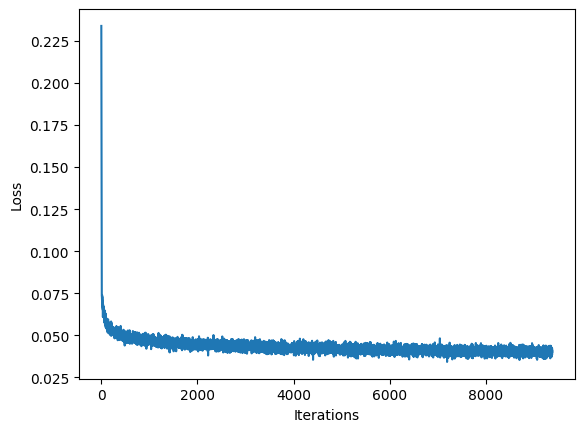

In [22]:
 # Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the losses
plt.plot(losses)

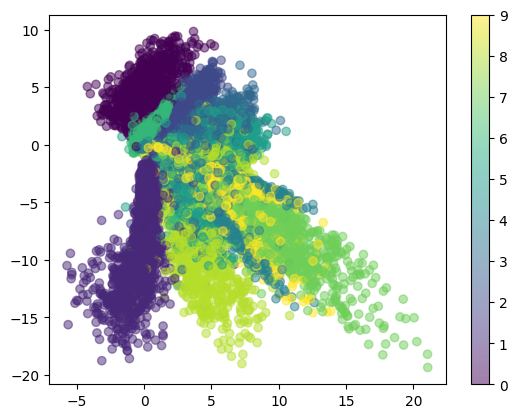

In [23]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.jpg')

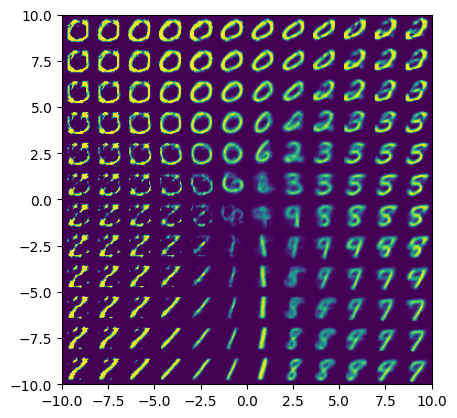

In [24]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.jpg')

test 2

In [25]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())
    
loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.23100151121616364
0/100: 0.05668136849999428
0/200: 0.0517454519867897
0/300: 0.05040523409843445
0/400: 0.048504166305065155
1/0: 0.046229224652051926
1/100: 0.049446333199739456
1/200: 0.049859289079904556
1/300: 0.0490545816719532
1/400: 0.04593242332339287
2/0: 0.04495152086019516
2/100: 0.0443999357521534
2/200: 0.04497639089822769
2/300: 0.0464293397963047
2/400: 0.04434053227305412
3/0: 0.047890555113554
3/100: 0.04161693528294563
3/200: 0.04383079335093498
3/300: 0.04324905946850777
3/400: 0.04540140554308891
4/0: 0.04393433406949043
4/100: 0.043425995856523514
4/200: 0.04761723428964615
4/300: 0.04685945808887482
4/400: 0.04343104735016823
5/0: 0.04704201966524124
5/100: 0.04384661465883255
5/200: 0.042030081152915955
5/300: 0.044192370027303696
5/400: 0.04126179218292236
6/0: 0.04416486620903015
6/100: 0.042726658284664154
6/200: 0.043536826968193054
6/300: 0.044081609696149826
6/400: 0.04420294985175133
7/0: 0.043561793863773346
7/100: 0.04101225361227989
7/200: 0.041

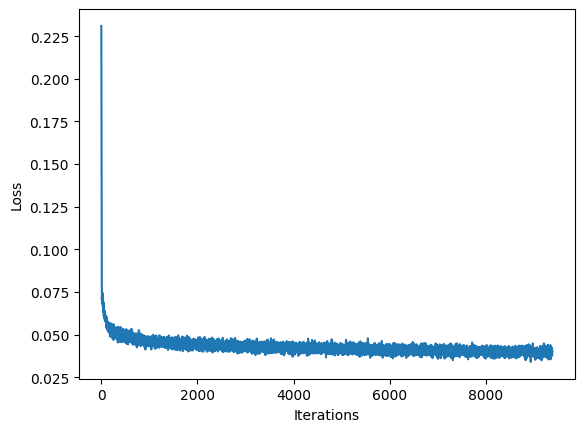

In [26]:
 # Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the losses
plt.plot(losses)

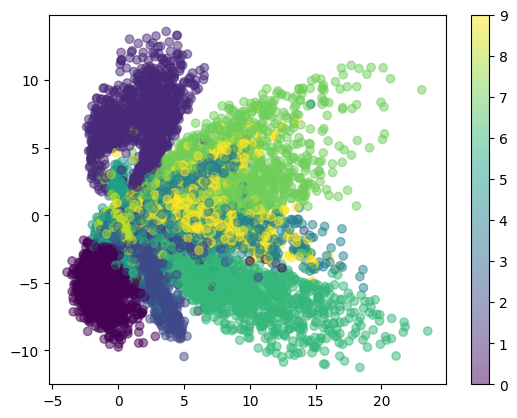

In [27]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.jpg')

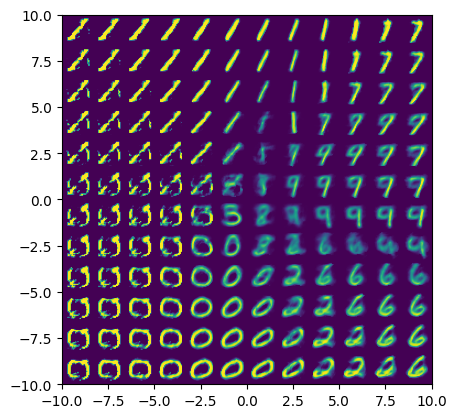

In [28]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.jpg')

test 3 

In [29]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())
    
loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.23575136065483093
0/100: 0.056983582675457
0/200: 0.053630050271749496
0/300: 0.048000261187553406
0/400: 0.05072009190917015
1/0: 0.05113648623228073
1/100: 0.04959547519683838
1/200: 0.04765145480632782
1/300: 0.044497013092041016
1/400: 0.04519256204366684
2/0: 0.04710553586483002
2/100: 0.045738715678453445
2/200: 0.04493461176753044
2/300: 0.0447823666036129
2/400: 0.047360848635435104
3/0: 0.043702445924282074
3/100: 0.045472152531147
3/200: 0.04439472034573555
3/300: 0.048162490129470825
3/400: 0.045976512134075165
4/0: 0.04583754390478134
4/100: 0.043461576104164124
4/200: 0.04372861236333847
4/300: 0.042811792343854904
4/400: 0.04685434326529503
5/0: 0.041221726685762405
5/100: 0.04354274272918701
5/200: 0.045702796429395676
5/300: 0.039934270083904266
5/400: 0.04286721721291542
6/0: 0.04439733549952507
6/100: 0.04118597134947777
6/200: 0.045284874737262726
6/300: 0.04137358441948891
6/400: 0.043495722115039825
7/0: 0.047256603837013245
7/100: 0.04447581619024277
7/200:

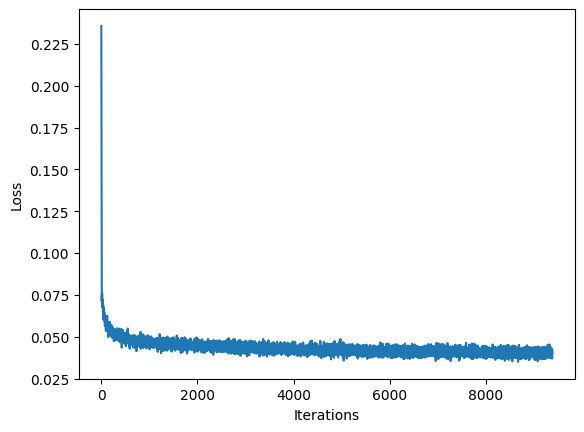

In [30]:
 # Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the losses
plt.plot(losses)

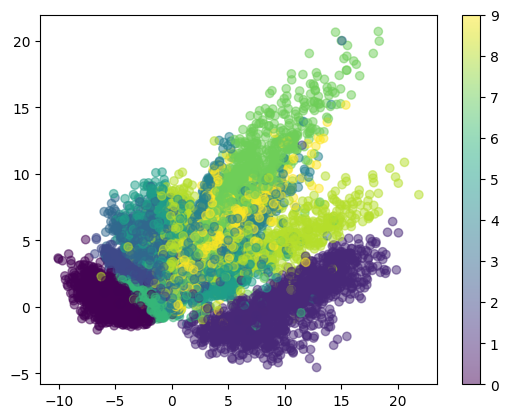

In [31]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.jpg')

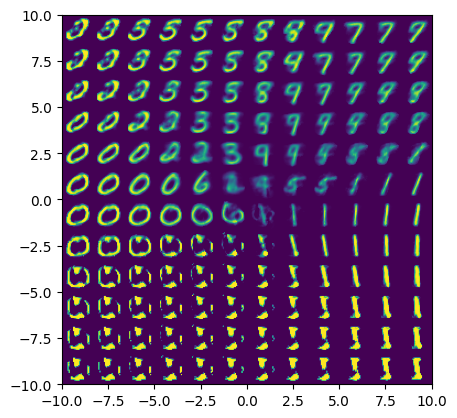

In [32]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.jpg')

PCA

In [50]:
#perform pca
pca = PCA(n_components=2)
pca.fit(data.data.reshape(n,w*h))
X_pca = pca.transform(data.data.reshape(n,w*h))

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


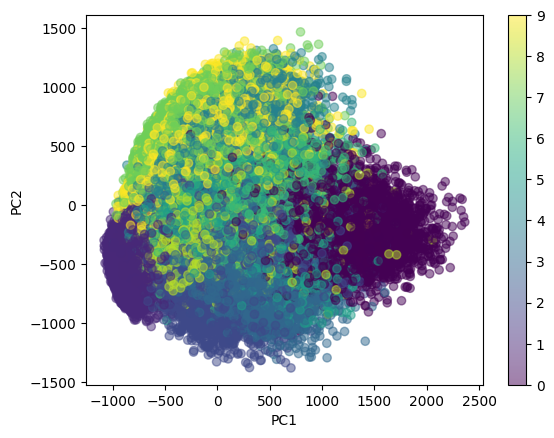

In [56]:
plt.scatter(X_pca[:,0], X_pca[:,1],c = data.train_labels, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

In [70]:
def plot_reconstructed_pca(x, w, h, r0=(-1000, 1500), r1=(-1500, 1500), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2)
            x_hat = pca.inverse_transform(z).reshape(w,h)
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

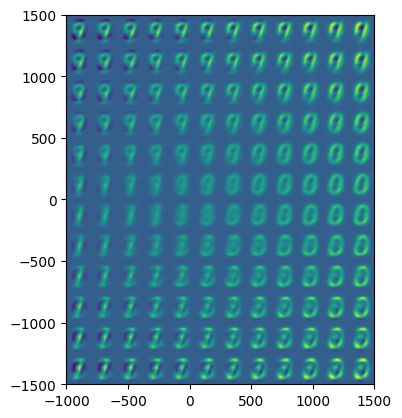

In [71]:
#plot grid of datapoint reconstructions
plot_reconstructed_pca(X_pca,w,h)

test 2

In [72]:
#perform pca
pca = PCA(n_components=2)
pca.fit(data.data.reshape(n,w*h))
X_pca = pca.transform(data.data.reshape(n,w*h))

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


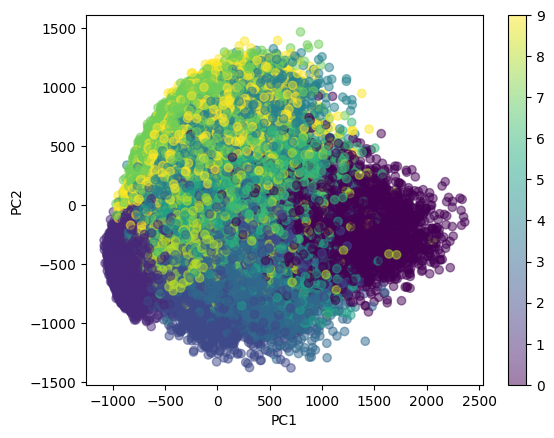

In [73]:
plt.scatter(X_pca[:,0], X_pca[:,1],c = data.train_labels, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

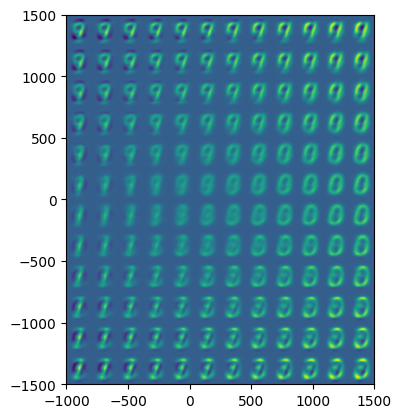

In [74]:
#plot grid of datapoint reconstructions
plot_reconstructed_pca(X_pca,w,h)

Convolutional Autoencoder

In [45]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential (
          nn.Conv2d (1 , 8 , kernel_size =(3 , 3) , stride =(2 , 2) , padding
          =(1 , 1) ),
          nn.ReLU (),
          nn.Conv2d (8 , 16 , kernel_size =(3 , 3) , stride =(2 , 2) , padding
          =(1 , 1) ),
          nn.ReLU (),
          nn.Conv2d (16 , 32 , kernel_size =(3 , 3) , stride =(2 , 2) ),
          nn.ReLU (),
          nn.Flatten ( start_dim =1 , end_dim = -1),
          nn.Linear ( in_features =288 , out_features =2 , bias = True )
    )
  def forward(self, input):
        return self.main(input)

In [44]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ConvNet()
        self.decoder = nn.Sequential (
      nn.Linear ( in_features =2 , out_features =288 , bias = True ),
      nn.Unflatten ( dim =1 , unflattened_size =(32 , 3, 3) ),
      nn.ConvTranspose2d (32 , 16 , kernel_size =(3 , 3) , stride =(2 ,
      2) ),
      nn.ReLU (),
      nn.ConvTranspose2d (16 , 8 , kernel_size =(3 , 3) , stride =(2 , 2)
      , padding =(1 , 1) , output_padding =(1 , 1) ),
      nn.ReLU (),
      nn.ConvTranspose2d (8 , 1, kernel_size =(3 , 3) , stride =(2 , 2) ,
      padding =(1 , 1) , output_padding =(1 , 1) ),
      nn.Sigmoid ()
      )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor()]
)

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = ConvAutoencoder()

optimizer = torch.optim.Adam(model.parameters())
    
loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.20728673040866852
0/100: 0.06944326311349869
0/200: 0.06846131384372711
0/300: 0.0675240084528923
0/400: 0.06666768342256546
1/0: 0.059864383190870285
1/100: 0.059458035975694656
1/200: 0.05724688991904259
1/300: 0.057826556265354156
1/400: 0.05610048025846481
2/0: 0.053906239569187164
2/100: 0.055505577474832535
2/200: 0.05233827978372574
2/300: 0.05216816067695618
2/400: 0.052049268037080765
3/0: 0.05015157163143158
3/100: 0.05297378450632095
3/200: 0.05275549367070198
3/300: 0.052413687109947205
3/400: 0.05527409911155701
4/0: 0.04963931813836098
4/100: 0.05377832055091858
4/200: 0.0517084114253521
4/300: 0.0518936812877655
4/400: 0.04915521666407585
5/0: 0.05164589732885361
5/100: 0.05126342922449112
5/200: 0.050205640494823456
5/300: 0.049616482108831406
5/400: 0.05084064602851868
6/0: 0.04944582283496857
6/100: 0.05292961373925209
6/200: 0.05005791410803795
6/300: 0.051090944558382034
6/400: 0.05095715448260307
7/0: 0.05361701920628548
7/100: 0.04907158017158508
7/200: 0.0

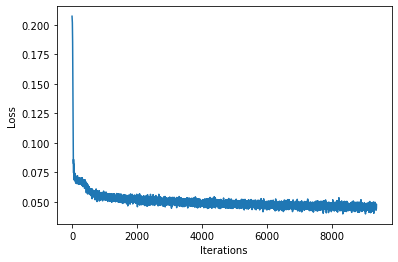

In [16]:
 # Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the losses
plt.plot(losses)

In [17]:
def plot_latent_conv(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, dim1], z[:, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

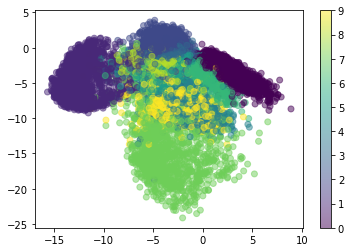

In [18]:
# Plot latent space
plot_latent_conv(data_loader, autoencoder.encoder)
plt.savefig('latent.jpg')

In [25]:
def plot_reconstructed_conv(decoder, w, h, r0=(-20, 5), r1=(-20, 0), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

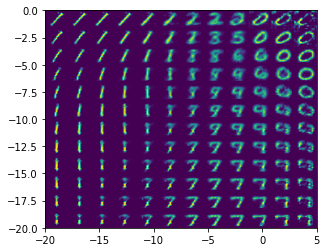

In [26]:
# Generate samples from latent space
plot_reconstructed_conv(autoencoder.decoder,w,h)
plt.savefig('reconstruction.jpg')

In [46]:
#model parameters for nn and CNN
model = ConvAutoencoder()
sum(p.numel() for p in model.parameters())

13187

In [39]:
model = Autoencoder(w*h,512,2)
sum(p.numel() for p in model.parameters())

806674